In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import os
import sys
sys.path.append('../src/')
sys.path.append('../problems/')
import model_vis
import models
import generation_utils
import tokenizer
import data_utils
from utils import get_best_checkpoint
from factorization import Factorization

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [4]:
pd.set_option('display.max_colwidth', 999)
pd.set_option('display.max_rows', 9999)

In [5]:
device = torch.device('cuda')

In [6]:
base_path = '../models/factorization/2^22/scaled/'

In [7]:
checkpoint = get_best_checkpoint(base_path)

Loading model at ../models/factorization/2^22/scaled/checkpoints/389150_0.0727.pt


In [8]:
args = checkpoint['args']

In [9]:
problem = Factorization(args)

In [10]:
t = problem.get_tokenizer()

In [11]:
args.keys()

dict_keys(['data', 'problem_type', 'model_args', 'optimizer', 'scheduler', 'loader', 'io', 'metrics', 'verbose', 'wandb', 'resume_training', 'tokenizer'])

In [12]:
model = models.Seq2SeqModel(n_tokens = args['tokenizer']['n_tokens'], 
                          pad_token_id = args['tokenizer']['pad_token_id'],
                          **args['model_args'])
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()

Seq2SeqModel(
  (src_embedding): TransformerEmbedding(
    (embedding): Embedding(34, 256)
  )
  (tgt_embedding): TransformerEmbedding(
    (embedding): Embedding(34, 256)
  )
  (positional_encoding): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-9): 10 x TransformerEncoderLayer(
          (self_attn): MultiHeadRelativeAttention(
            (w_q): Linear(in_features=256, out_features=256, bias=False)
            (w_k): Linear(in_features=256, out_features=256, bias=False)
            (w_v): Linear(in_features=256, out_features=256, bias=False)
            (out_proj): Linear(in_features=256, out_features=256, bias=False)
            (pe_mod): PositionalEncoding(
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (w_k_pos): Linear(in_features=256, out_features=256, bias=False)
          )
          (linear1): Linear(in_features=256,

In [13]:
example_row = problem.solve(54312, model, device, args['model_args']['max_decode_size'], n_beams = 1, temperature=1, return_type='df')

In [14]:
example_row

,input_num,model_input,beam_idx,log_prob,pred_str,pred_factor_list,product,num_pred_factors,num_prime_factors_pred,percent_prime_factors_pred,correct_product,correct_factorization,pred_same_as_input,input_is_prime,target_factor_str,target_factor_list,num_target_factors,min_target_prime_factor_if_composite
0,54312,"[[SOS], 2, 0, 10, 12, [EOS]]",0,-0.000009,[SOS] 2 * 2 * 2 * 3 * 1 1 * 2 13 [EOS],"[2, 2, 2, 3, 31, 73]",54312,6,6,1.0,True,True,False,False,[SOS] 2 * 2 * 2 * 3 * 1 1 * 2 13 [EOS],"[2, 2, 2, 3, 31, 73]",6,2


In [15]:
example_row['correct_product'].any()

True

In [16]:
example_row['correct_factorization'].any()

True

In [23]:
input = t.encode(problem.form_input(example_row['input_num'].iloc[0], args['data']['base']))
tgt = t.encode(example_row['pred_str'].iloc[0].replace('_', '').strip().split(' '))

In [24]:
input

[33, 2, 0, 10, 12, 32]

In [25]:
tgt

[33, 2, 30, 2, 30, 2, 30, 3, 30, 1, 1, 30, 2, 13, 32]

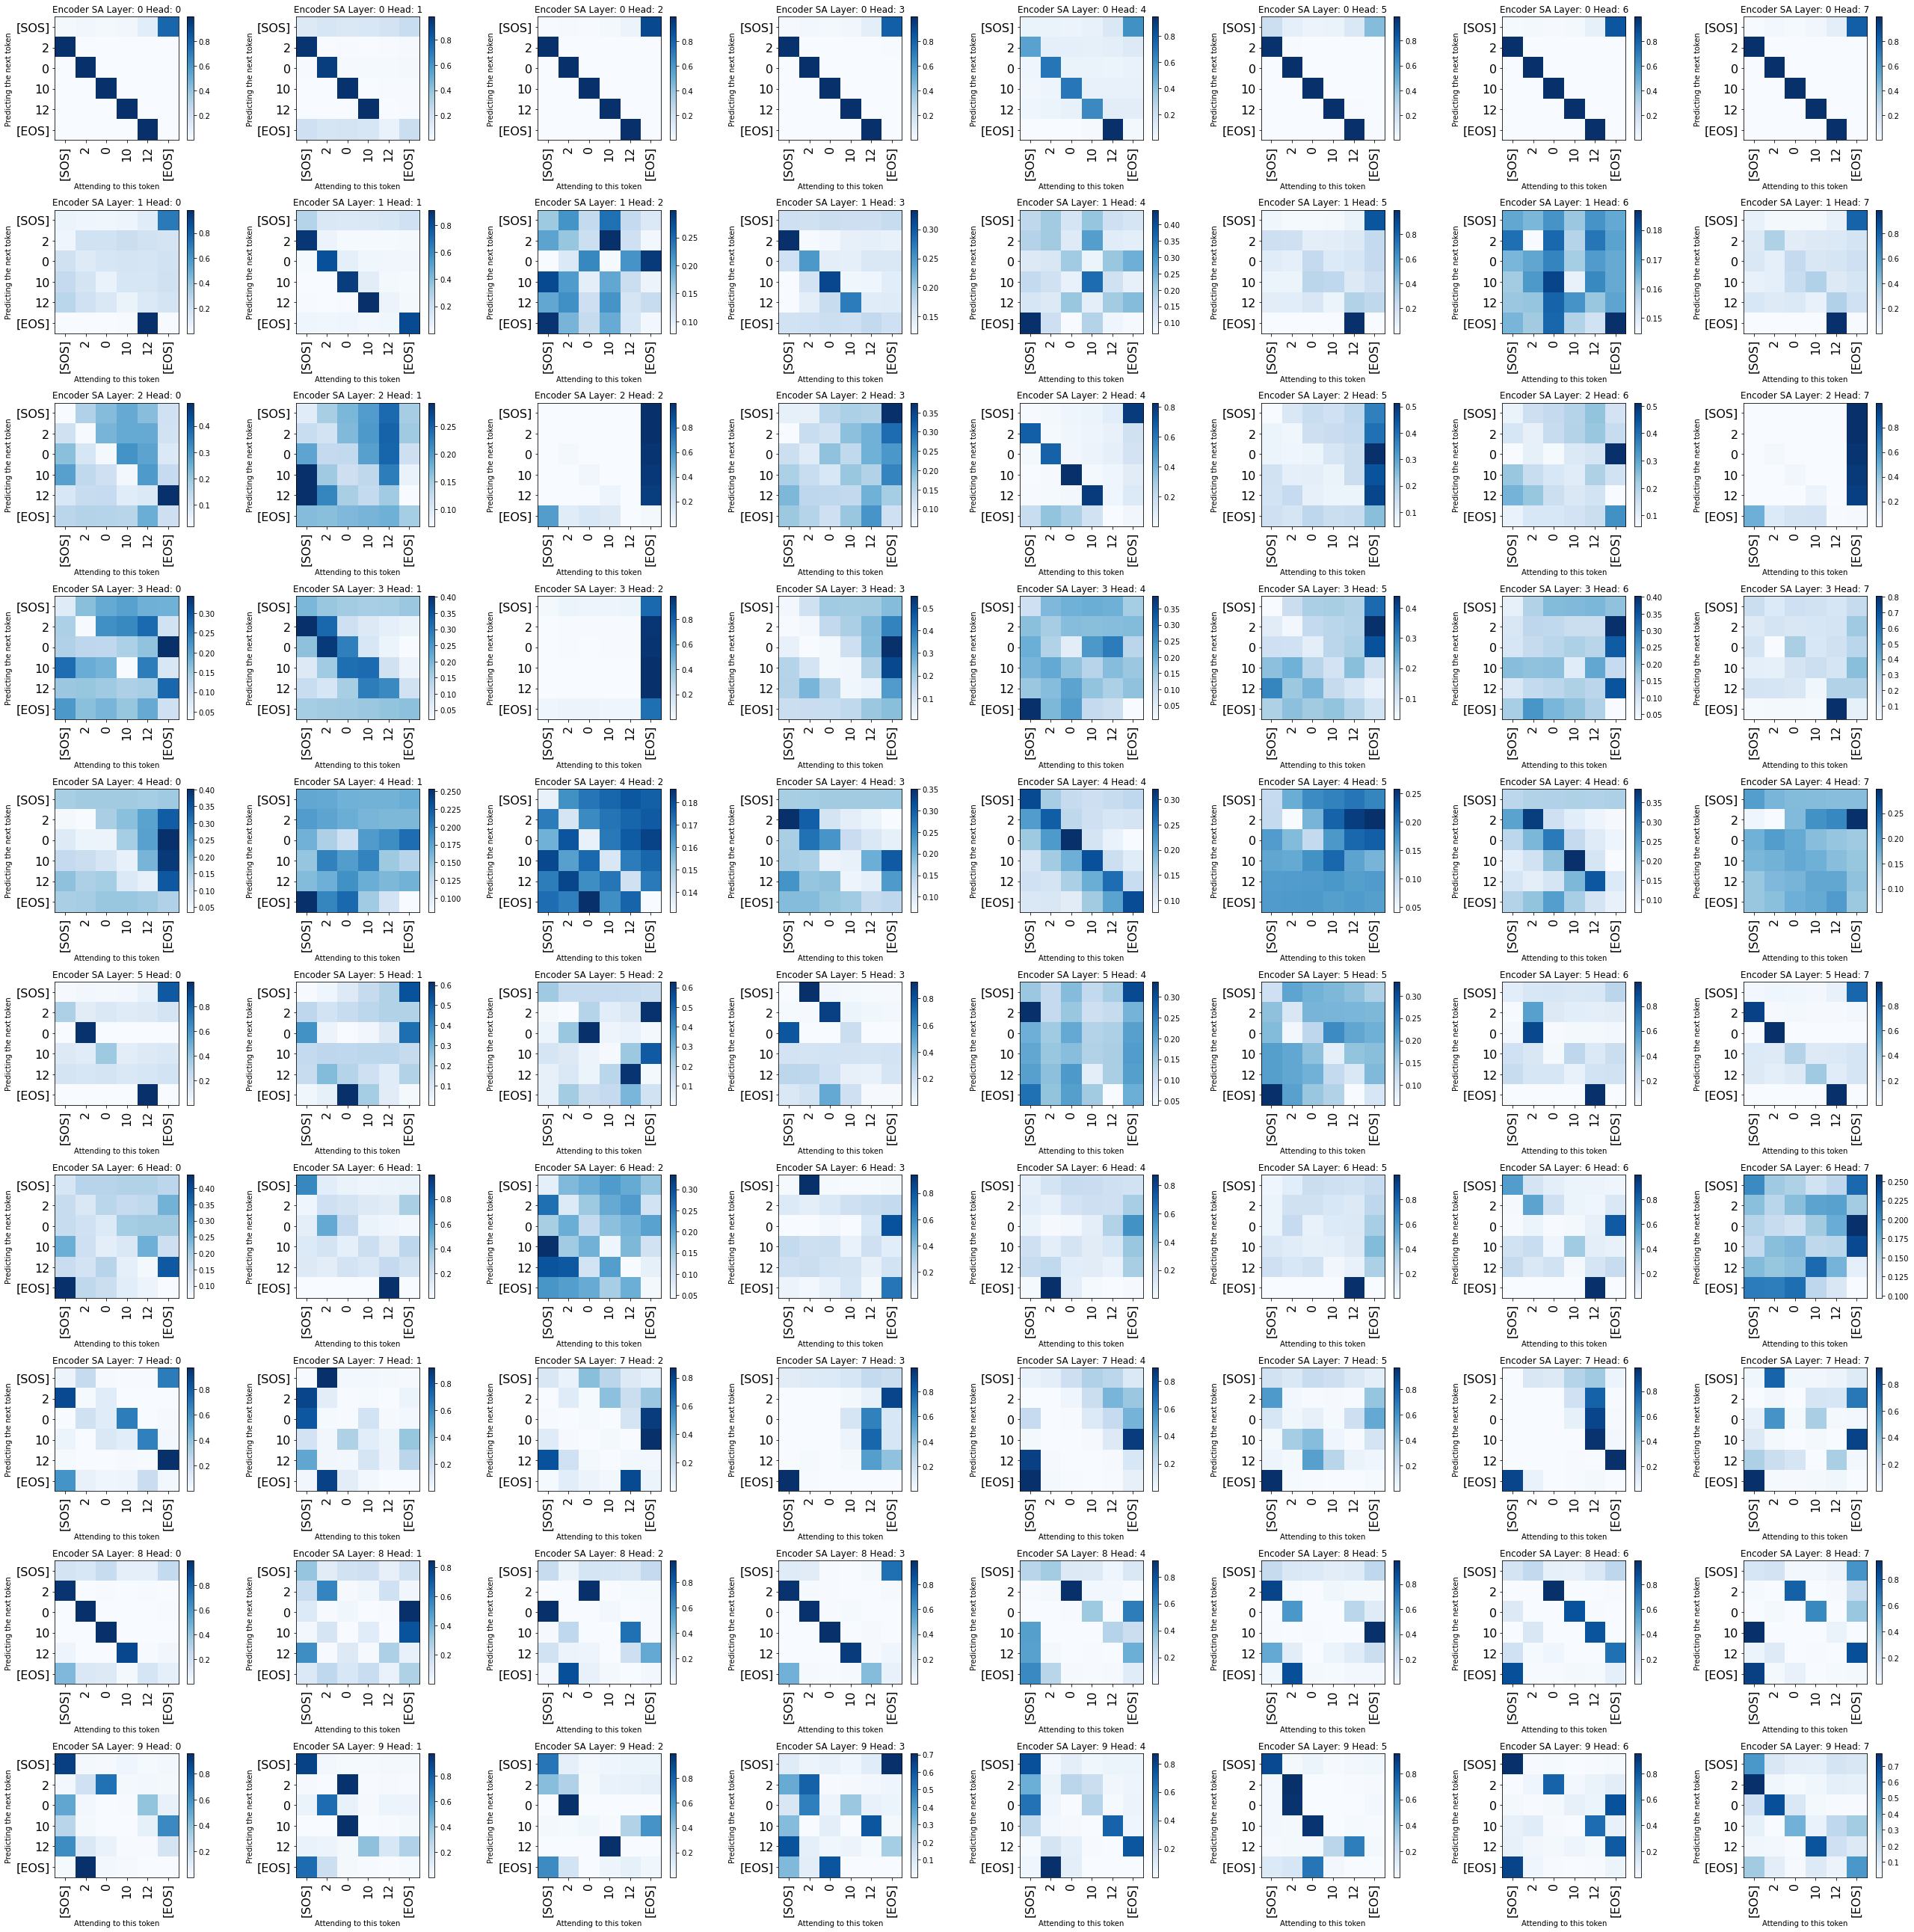

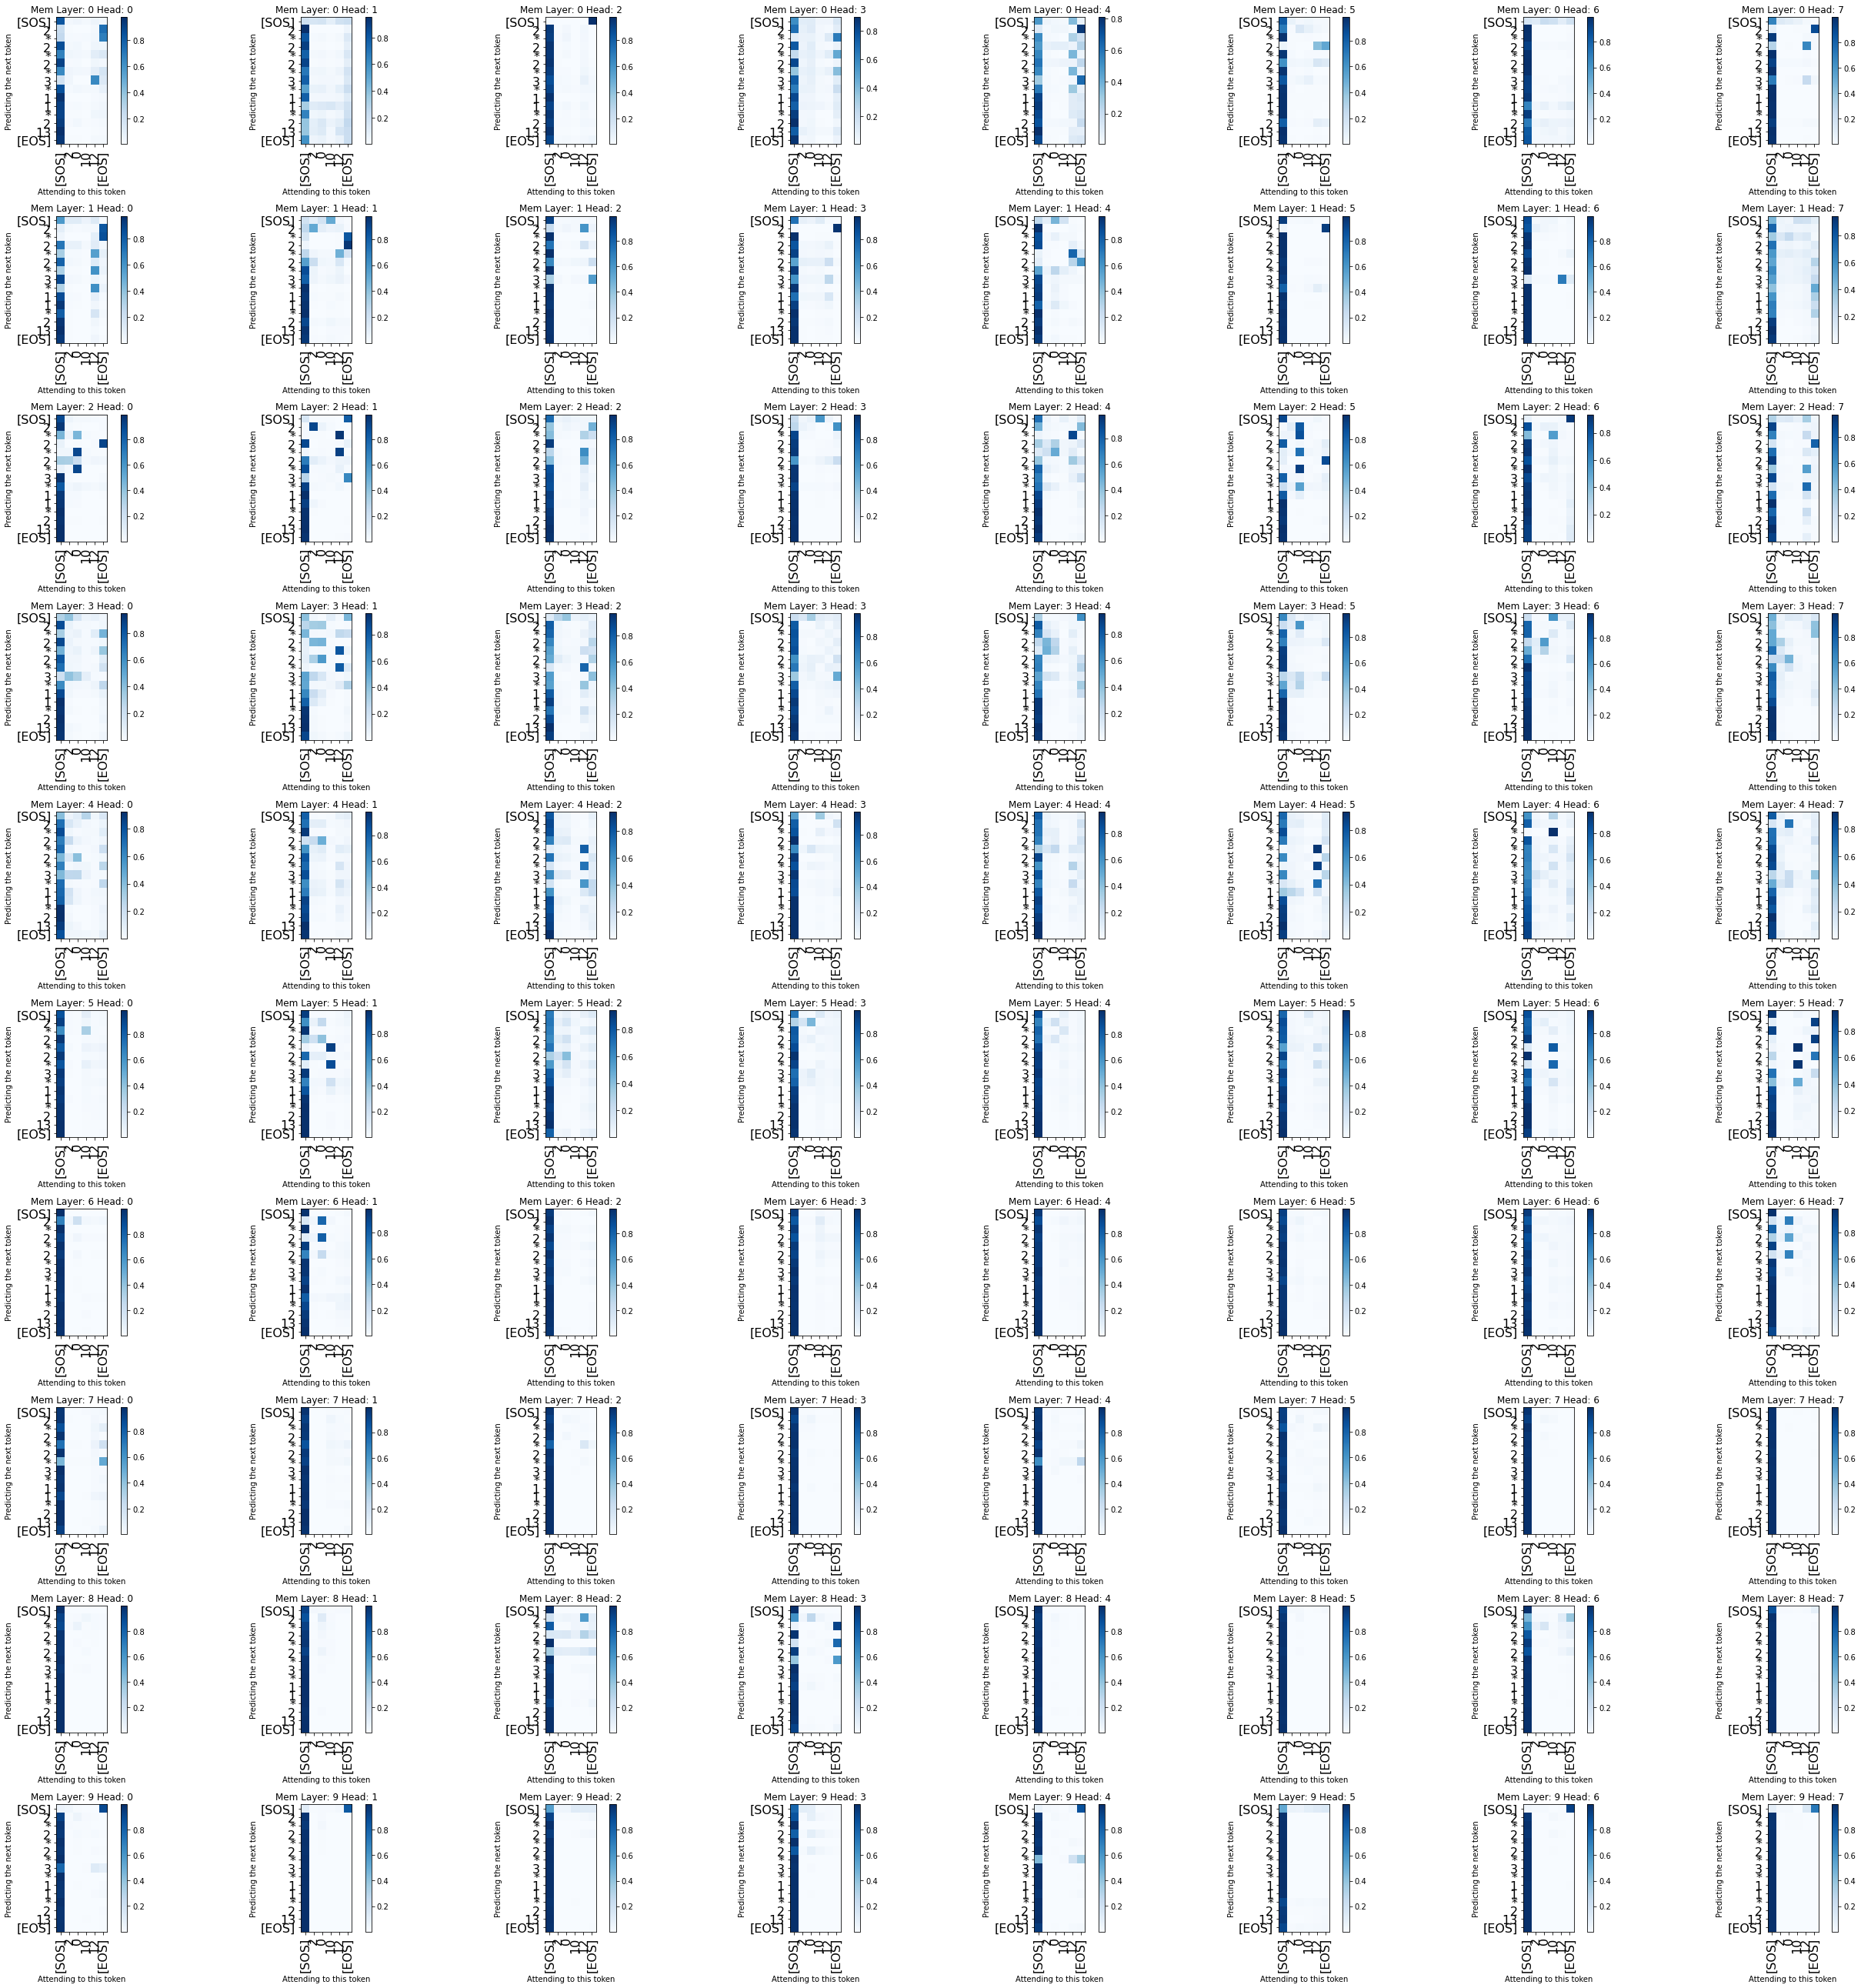

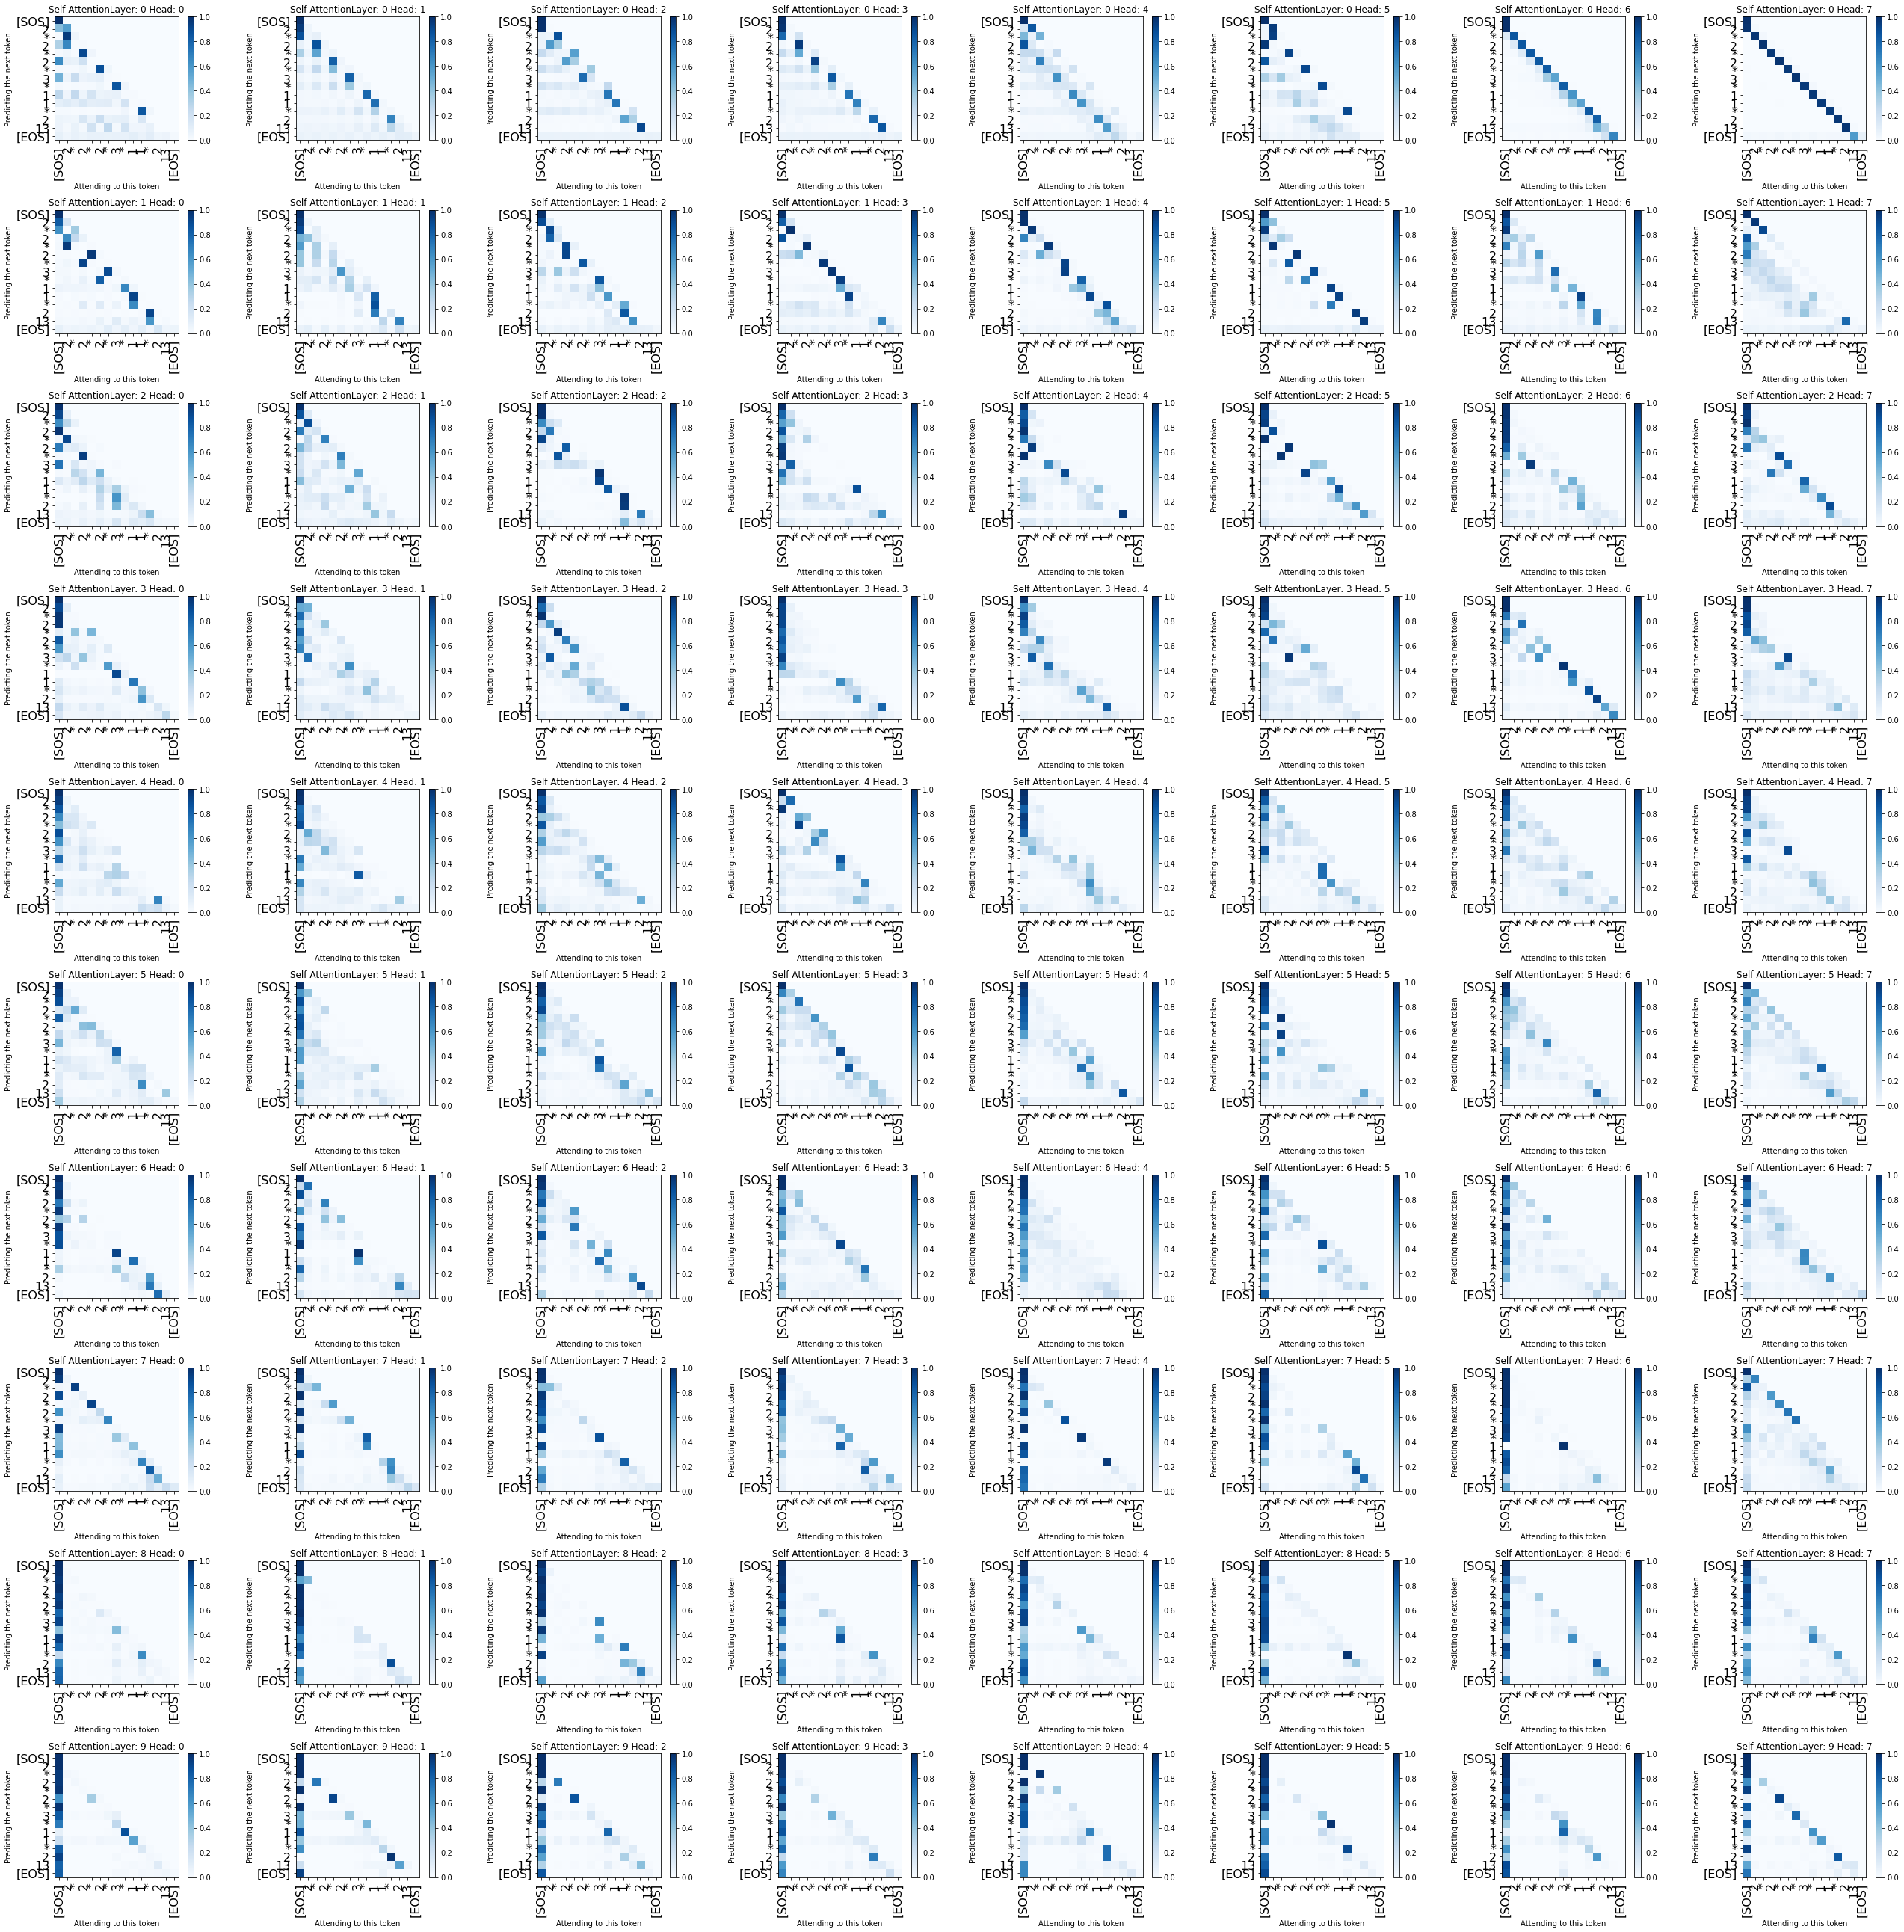

In [26]:
model_vis.visualize_attention(input, tgt, model, t, device)